In [1]:
#pip install tensorflow

In [2]:
#pip install opencv-python-headless

In [90]:
from distutils import extension
from logging import exception
import os
from datetime import datetime as dt
from regex import E
from sqlalchemy import intersect
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np 
import pathlib
from keras.callbacks import ModelCheckpoint   
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/cbisddsm"

Test_output_full  Test_output_mask  Train_output_full  Train_output_mask


In [6]:
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Images/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Images/Test')

In [7]:
seed = 43
encoder_input_width = 224
encode_input_channels = 3
encoder_input_shape = (encoder_input_width, encoder_input_width, encode_input_channels)

kernsize = 3
decoder_kernel_size = (kernsize, kernsize)
stride = 2
decoder_strides = (stride, stride)
decoder_padding = "same"
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"

train_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_full"
train_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_mask"

test_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_full"
test_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_mask"
results_dir = "/content/results/fit"
extension = ".png"

target_size = (224, 224)

brightness_delta = 0.3
batch_size = 10

validate = False
loss = "binary_crossentropy"
learning_rate = 0.0001
dropout = 0.5
dropout_training = True
num_epochs = 80
callback_monitor = "iouMetric"
callback_mode = "max"
ckpt_save_weights_only = True
ckpt_save_best_only = True
earlystop_patience = 200
restore_best_weights = True

In [8]:
# x_paths_list = []
# for full in os.listdir(train_full_img_dir):
#   if full.endswith(extension):
#     x_paths_list.append(os.path.join(train_full_img_dir, full))

# print(len(x_paths_list))

In [9]:
def datasetPaths(full_img_dir, mask_img_dir):
        try:
            x_paths_list = []
            y_paths_list = []

            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))
            
            for full in os.listdir(mask_img_dir):
                if full.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, full))
            
            x_paths_list.sort()
            y_paths_list.sort()

            return x_paths_list, y_paths_list
        except Exception as e:
            print(f"Error in datasetPaths {e}")

In [10]:
# def loadFullImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path = path.decode()
             
            
#             s3_client = boto3.resource('s3')
#             obj = s3_client.get_object(Bucket='cbisddsm', Key=path)
#             nparr = np.frombuffer(obj['Body'].read(), np.uint8)
#             img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#             print(f'type type{img}')
#             #bucket = s3_resource.Bucket('cbisddsm')
#             #print(f'bucket.Object(path) {bucket.Object(path)}')
#             #img = bucket.Object(path).get().get('Body').read()
#             #print(f'img {img}')
#             #img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
           
            
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
#             print(f'done for path {path}')
#             return full_img
        
#         except Exception as e:
#             print(f"There is an error in loadFullImg {e}")
            

    
 

In [11]:
def loadFullImg(path, dsize):
        try:
            if not isinstance(path, str):
                path = path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            #print(type(img))
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())
            #print(f'After norm_img')
            #print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            #print(f'After full_img')
            #print(f'type {full_img.shape}')
            #print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [12]:
# s3 = boto3.resource('s3')
# my_bucket = s3.Bucket('cbisddsm')
# i = 0
# for object_summary in my_bucket.objects.filter(Prefix='Train_output_full'):    
#     if i == 0:
#         pass
#     else:
#         print(object_summary.key)
#         img = loadFullImg(object_summary.key, target_size)
#         print(img.shape)
#         #break
#     i += 1
    
    
#             #print(object_summary.key)
        
#             #x_paths_list.append(object_summary.key)


In [37]:
def loadMaskImg(path, dsize):
        try:
            if not isinstance(path, str):
                path=path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            #print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [14]:
# def loadMaskImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path=path.decode()
             
#             s3_resource = boto3.resource('s3')
#             bucket = s3_resource.Bucket('cbisddsm')
# #             bucket = s3_resource.Bucket('cbisddsm')
#             img = bucket.Object(path).get().get('Body').read()
#             img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
#             print(f'type type(img)')
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             mask_img = np.expand_dims(norm_img, axis=-1)

#             return mask_img

#         except Exception as e:
#             print("Error in loadMaskIMG")

In [15]:
def tfParse(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [16]:
def imgAugment(x_img, y_img):
        try:
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            x_img = tf.image.random_brightness(
                image=x_img, max_delta=brightness_delta
            )

            return x_img, y_img

        except:
            print("Erro in imgAugument")

In [17]:
 def makeTFDataset( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [18]:
def buildEncoder():
        try:
            VGG16_ = keras.applications.VGG16(
                include_top=False, weights="imagenet", input_shape=encoder_input_shape,
            )

            layer_names = [layer.name for layer in VGG16_.layers]

            all_layer_outputs = [
               VGG16_.get_layer(layer).output for layer in layer_names
            ]

            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            encoder_model.trainable = False

            return encoder_model 
        
        except Exception as e:
            print("Error in buildEncoder")

In [19]:
def buildUnet():
        try:
            unet_input = keras.Input(
                shape= encoder_input_shape, name="unet_input_layer"
            )

            x = unet_input
            encoder_model = buildEncoder()
            all_encoder_layer_outputs = encoder_model(x)

            encoded_img = all_encoder_layer_outputs[-1]

            #skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5,9, 13, 17]]
            skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 4, 6, 12, 15]]
            
            decoder_filters = int(encoded_img.shape[-1])

            # ------------------------------------------
            # Block 5: 7x7 -> 14x14
            #  - `encoded_img` as initial input for decoder
            x = keras.layers.Conv2DTranspose(
                name="block5_up_convT",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                activation=decoder_activation,
            )(encoded_img)

            x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
                [x, skip_outputs[4]]
            )

            x = keras.layers.Dropout(
                name="block5_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block5_up_conv3",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv2",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv1",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 4: 14x14 -> 28x28
            x = keras.layers.Conv2DTranspose(
                name="block4_up_convT",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
                [x, skip_outputs[3]]
            )

            x = keras.layers.Dropout(
                name="block4_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block4_up_conv3",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv2",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv1",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 3: 28x28 -> 56x56
            x = keras.layers.Conv2DTranspose(
                name="block3_up_convT",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
                [x, skip_outputs[2]]
            )

            x = keras.layers.Dropout(
                name="block3_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block3_up_conv3",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv2",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv1",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 2: 56x56 -> 112x112
            x = keras.layers.Conv2DTranspose(
                name="block2_up_convT",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
                [x, skip_outputs[1]]
            )

            x = keras.layers.Dropout(
                name="block2_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block2_up_conv2",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block2_up_conv1",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 1: 112x112 -> 224x224
            x = keras.layers.Conv2DTranspose(
                name="block1_up_convT",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
                [x, skip_outputs[0]]
            )

            x = keras.layers.Dropout(
                name="block1_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block1_up_conv2",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation="relu",
            )(x)
            decoded_img = keras.layers.Conv2D(
                name="block1_up_conv1",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation="relu",
            )(x)

            # ------------------------------------------
            # Final conv layer
            final_img = keras.layers.Conv2D(
                name="final_up_conv",
                filters=final_layer_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                activation=final_layer_activation,
            )(decoded_img)

            # ======
            #  Unet
            # ======

            unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")

            return unet
        except Exception as e:
            print(f"Error in Build Unet {e}")

In [20]:
def iouMetric( y_true, y_pred):
        try:
            def compute_iou(y_true, y_pred):
                intersection = (y_true * y_pred).sum()
                union = y_true.sum() + y_pred.sum() - intersection
                x = (intersection + 1e-15) / (union + 1e-15)
                x = x.astype(np.float32)
                return x
            
            return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)
            
        except Exception as e:
            print(f"Error in iouMetric {E}")

In [21]:
def dice_coef(y_true, y_pred):
        try:
            # def dice(true, pred, k = 1):
            #     intersection = np.sum(pred[true==k]) * 2.0
            #     dice = intersection / (np.sum(pred) + np.sum(true))
            #     return dice 
            # return tf.numpy_function(dice, [y_true, y_pred], tf.double)
            
            y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
            y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
        except Exception as e:
            print(f"Error in dice_coef {e}")

In [22]:
def compile_( model):
        try:
            loss = keras.losses.BinaryCrossentropy(from_logits=False)
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            metrics = ["accuracy", iouMetric, dice_coef]
            model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

            return model
        except Exception as e:
            print(f"Failed at compile_ {e}")

In [23]:
 test_x, test_y = datasetPaths(
            full_img_dir=test_full_img_dir,
            mask_img_dir=test_mask_img_dir
        )
        

In [24]:
# def evaluate(path,target_size):
#   full_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     full_img = loadFullImg(imgpath, target_size)
#     full_img_lst.append(full_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return full_img_lst
  
# full_img_lst = evaluate(test_x, target_size)

In [25]:
# def evaluate_mask(path,target_size):
#   mask_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     mask_img = loadMaskImg(imgpath, target_size)
#     mask_img_lst.append(mask_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return mask_img_lst
  
# mask_img_lst = evaluate(test_y, target_size)

In [26]:
# img = cv2.imread(test_x[0], cv2.IMREAD_GRAYSCALE)
# print(img)

In [27]:
# actual_x, actual_y =tfParse(test_x, test_y)

In [28]:
# full_img_lst[0]

In [29]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1)  
model_time = dt.now().strftime("%Y%m%d_%H%M%S")
model_folder = os.path.join(results_dir, model_time)
os.makedirs(model_folder)

tensorboard_folder = os.path.join(model_folder, "tensorlogs")
os.makedirs(tensorboard_folder)

ckpt_folder = os.path.join(model_folder, "checkpoints")
os.makedirs(ckpt_folder)

csv_logger_folder = os.path.join(model_folder, "csv_logger")
os.makedirs(csv_logger_folder)

hist_folder = os.path.join(model_folder, "model_history")
os.makedirs(hist_folder)

saved_model_folder = os.path.join(model_folder, "Saved_model")
os.makedirs(saved_model_folder)

model_params_folder = os.path.join(model_folder, "model_params")
os.makedirs(model_params_folder)

train_x, train_y = datasetPaths(
    full_img_dir=train_full_img_dir,
    mask_img_dir=train_mask_img_dir 
)

test_x, test_y = datasetPaths(
    full_img_dir=test_full_img_dir,
    mask_img_dir=test_mask_img_dir
)

train_ds = makeTFDataset(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)


test_ds = makeTFDataset(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)      
    
unet = buildUnet()

unet = compile_(model=unet)

# ckpt_path = (ckpt_folder + f"/{model_time}" + "_Epoch-{epoch:03d}" + "_IOU-{iouMetric:.8f")
ckpt_path = (ckpt_folder + f"/{model_time}")

ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath= ckpt_path,
    monitors= callback_monitor,
    mode= callback_mode,
    save_weights_only= ckpt_save_weights_only,
    save_best_only=ckpt_save_best_only,
    verbose=1
)

es_callback = keras.callbacks.EarlyStopping(
    patience= earlystop_patience,
    monitor= callback_monitor,
    mode= callback_mode,
    restore_best_weights= restore_best_weights,
)

# TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_folder, histogram_freq=1, profile_batch=0
)

# CSV Logger
csv_logger_path = os.path.join(csv_logger_folder, "csv_logger.csv")
csv_logger = keras.callbacks.CSVLogger(
    filename=csv_logger_path, separator=",", append=True
)

# Putting them together
callbacks = [ckpt_callback, es_callback, tb_callback, csv_logger, checkpointer]

train_steps = len(train_x) // batch_size
test_steps = len(test_x) // batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(test_x) % batch_size != 0:
    test_steps += 1

print()
print(f"Size of training set = {len(train_x)}")
print(f"Size of test set = {len(test_x)}")
print(f"Number of epochs = {num_epochs}")
print(f"Batch size = {batch_size}")
print(f"Number of training steps per epoch = {train_steps}")
print(f"Number of test steps per epoch = {test_steps}")
print()

if validate:
        history = unet.fit(
            train_ds,
            validation_data=test_ds,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            validation_steps=test_steps,
            callbacks=callbacks,
            verbose=1,
        )
elif not validate:
    history = unet.fit(
        train_ds,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        callbacks=callbacks,
        verbose=1,
    )

#y_hat = unet.evaluate(test_ds)

print("Completed")     
        

58900480/58889256 [==============================] - 0s 0us/step

Size of training set = 1231
Size of test set = 361
Number of epochs = 80
Batch size = 10
Number of training steps per epoch = 124
Number of test steps per epoch = 37

Epoch 1/80
124/124 [==============================] - ETA: 0s - loss: 15.3778 - accuracy: 0.9832 - iouMetric: 0.0017 - dice_coef: 0.0037


Epoch 1: saving model to model.weights.best.hdf5
124/124 [==============================] - 379s 3s/step - loss: 15.3778 - accuracy: 0.9832 - iouMetric: 0.0017 - dice_coef: 0.0037
Epoch 2/80
124/124 [==============================] - ETA: 0s - loss: 3.1659 - accuracy: 0.9959 - iouMetric: 0.0238 - dice_coef: 0.0464


Epoch 2: saving model to model.weights.best.hdf5
124/124 [==============================] - 223s 2s/step - loss: 3.1659 - accuracy: 0.9959 - iouMetric: 0.0238 - dice_coef: 0.0464
Epoch 3/80
124/124 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.9959 - iouMetric: 0.0503 - dice_coef: 0.0954


Epoch 3: saving model to model.weights.best.hdf5
124/124 [==============================] - 224s 2s/step - loss: 1.0728 - accuracy: 0.9959 - iouMetric: 0.0503 - dice_coef: 0.0954
Epoch 4/80
123/124 [============================>.] - ETA: 1s - loss: 0.6811 - accuracy: 0.9960 - iouMetric: 0.0740 - dice_coef: 0.1372


Epoch 4: saving model to model.weights.best.hdf5
124/124 [==============================] - 224s 2s/step - loss: 0.6810 - accuracy: 0.9960 - iouMetric: 0.0744 - dice_coef: 0.1379
Epoch 5/80
123/124 [============================>.] - ETA: 1s - loss: 0.5302 - accuracy: 0.9960 - iouMetric: 0.0876 - dice_coef: 0.1599


Epoch 5: saving model to model.weights.best.hdf5
124/124 [==============================] - 224s 2s/step - loss: 0.5302 - accuracy: 0.9960 - iouMetric: 0.0870 - dice_coef: 0.1589
Epoch 6/80
123/124 [============================>.] - ETA: 1s - loss: 0.4307 - accuracy: 0.9961 - iouMetric: 0.0861 - dice_coef: 0.1573


Epoch 6: saving model to model.weights.best.hdf5
124/124 [==============================] - 222s 2s/step - loss: 0.4307 - accuracy: 0.9961 - iouMetric: 0.0856 - dice_coef: 0.1563
Epoch 7/80
124/124 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.9962 - iouMetric: 0.1038 - dice_coef: 0.1867


Epoch 7: saving model to model.weights.best.hdf5
124/124 [==============================] - 225s 2s/step - loss: 0.3559 - accuracy: 0.9962 - iouMetric: 0.1038 - dice_coef: 0.1867
Epoch 8/80
123/124 [============================>.] - ETA: 1s - loss: 0.2988 - accuracy: 0.9963 - iouMetric: 0.1112 - dice_coef: 0.1971


Epoch 8: saving model to model.weights.best.hdf5
124/124 [==============================] - 225s 2s/step - loss: 0.2988 - accuracy: 0.9963 - iouMetric: 0.1133 - dice_coef: 0.2000
Epoch 9/80
123/124 [============================>.] - ETA: 1s - loss: 0.2537 - accuracy: 0.9964 - iouMetric: 0.1216 - dice_coef: 0.2140


Epoch 9: saving model to model.weights.best.hdf5
124/124 [==============================] - 223s 2s/step - loss: 0.2537 - accuracy: 0.9964 - iouMetric: 0.1210 - dice_coef: 0.2131
Epoch 10/80
123/124 [============================>.] - ETA: 1s - loss: 0.2180 - accuracy: 0.9963 - iouMetric: 0.1170 - dice_coef: 0.2072


Epoch 10: saving model to model.weights.best.hdf5
124/124 [==============================] - 224s 2s/step - loss: 0.2179 - accuracy: 0.9963 - iouMetric: 0.1175 - dice_coef: 0.2080
Epoch 11/80
123/124 [============================>.] - ETA: 1s - loss: 0.1880 - accuracy: 0.9964 - iouMetric: 0.1277 - dice_coef: 0.2233


Epoch 11: saving model to model.weights.best.hdf5
124/124 [==============================] - 224s 2s/step - loss: 0.1880 - accuracy: 0.9964 - iouMetric: 0.1285 - dice_coef: 0.2245
Epoch 12/80
123/124 [============================>.] - ETA: 1s - loss: 0.1633 - accuracy: 0.9965 - iouMetric: 0.1390 - dice_coef: 0.2410


Epoch 12: saving model to model.weights.best.hdf5
124/124 [==============================] - 225s 2s/step - loss: 0.1634 - accuracy: 0.9965 - iouMetric: 0.1380 - dice_coef: 0.2393
Epoch 13/80
123/124 [============================>.] - ETA: 1s - loss: 0.1430 - accuracy: 0.9964 - iouMetric: 0.1287 - dice_coef: 0.2253


Epoch 13: saving model to model.weights.best.hdf5
124/124 [==============================] - 224s 2s/step - loss: 0.1430 - accuracy: 0.9964 - iouMetric: 0.1286 - dice_coef: 0.2252
Epoch 14/80
123/124 [============================>.] - ETA: 1s - loss: 0.1253 - accuracy: 0.9965 - iouMetric: 0.1378 - dice_coef: 0.2389


Epoch 14: saving model to model.weights.best.hdf5
124/124 [==============================] - 227s 2s/step - loss: 0.1253 - accuracy: 0.9965 - iouMetric: 0.1373 - dice_coef: 0.2381
Epoch 15/80
123/124 [============================>.] - ETA: 1s - loss: 0.1104 - accuracy: 0.9965 - iouMetric: 0.1441 - dice_coef: 0.2486


Epoch 15: saving model to model.weights.best.hdf5
124/124 [==============================] - 226s 2s/step - loss: 0.1104 - accuracy: 0.9965 - iouMetric: 0.1436 - dice_coef: 0.2478
Epoch 16/80
123/124 [============================>.] - ETA: 1s - loss: 0.0976 - accuracy: 0.9966 - iouMetric: 0.1489 - dice_coef: 0.2555


Epoch 16: saving model to model.weights.best.hdf5
124/124 [==============================] - 225s 2s/step - loss: 0.0976 - accuracy: 0.9966 - iouMetric: 0.1477 - dice_coef: 0.2535
Epoch 17/80
124/124 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9965 - iouMetric: 0.1365 - dice_coef: 0.2369


Epoch 17: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0872 - accuracy: 0.9965 - iouMetric: 0.1365 - dice_coef: 0.2369
Epoch 18/80
123/124 [============================>.] - ETA: 1s - loss: 0.0773 - accuracy: 0.9965 - iouMetric: 0.1411 - dice_coef: 0.2437


Epoch 18: saving model to model.weights.best.hdf5
124/124 [==============================] - 209s 2s/step - loss: 0.0773 - accuracy: 0.9965 - iouMetric: 0.1412 - dice_coef: 0.2439
Epoch 19/80
123/124 [============================>.] - ETA: 1s - loss: 0.0692 - accuracy: 0.9966 - iouMetric: 0.1517 - dice_coef: 0.2606


Epoch 19: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0691 - accuracy: 0.9966 - iouMetric: 0.1505 - dice_coef: 0.2587
Epoch 20/80
123/124 [============================>.] - ETA: 1s - loss: 0.0620 - accuracy: 0.9966 - iouMetric: 0.1515 - dice_coef: 0.2597


Epoch 20: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0620 - accuracy: 0.9966 - iouMetric: 0.1506 - dice_coef: 0.2582
Epoch 21/80
123/124 [============================>.] - ETA: 1s - loss: 0.0558 - accuracy: 0.9966 - iouMetric: 0.1477 - dice_coef: 0.2538


Epoch 21: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0558 - accuracy: 0.9966 - iouMetric: 0.1489 - dice_coef: 0.2555
Epoch 22/80
123/124 [============================>.] - ETA: 1s - loss: 0.0504 - accuracy: 0.9966 - iouMetric: 0.1563 - dice_coef: 0.2663


Epoch 22: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0504 - accuracy: 0.9966 - iouMetric: 0.1560 - dice_coef: 0.2660
Epoch 23/80
123/124 [============================>.] - ETA: 1s - loss: 0.0456 - accuracy: 0.9966 - iouMetric: 0.1554 - dice_coef: 0.2645


Epoch 23: saving model to model.weights.best.hdf5
124/124 [==============================] - 208s 2s/step - loss: 0.0456 - accuracy: 0.9966 - iouMetric: 0.1541 - dice_coef: 0.2626
Epoch 24/80
123/124 [============================>.] - ETA: 1s - loss: 0.0416 - accuracy: 0.9966 - iouMetric: 0.1587 - dice_coef: 0.2707


Epoch 24: saving model to model.weights.best.hdf5
124/124 [==============================] - 208s 2s/step - loss: 0.0416 - accuracy: 0.9966 - iouMetric: 0.1575 - dice_coef: 0.2686
Epoch 25/80
123/124 [============================>.] - ETA: 1s - loss: 0.0379 - accuracy: 0.9966 - iouMetric: 0.1538 - dice_coef: 0.2634


Epoch 25: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0379 - accuracy: 0.9966 - iouMetric: 0.1526 - dice_coef: 0.2614
Epoch 26/80
123/124 [============================>.] - ETA: 1s - loss: 0.0347 - accuracy: 0.9966 - iouMetric: 0.1542 - dice_coef: 0.2638


Epoch 26: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0346 - accuracy: 0.9966 - iouMetric: 0.1541 - dice_coef: 0.2637
Epoch 27/80
123/124 [============================>.] - ETA: 1s - loss: 0.0320 - accuracy: 0.9965 - iouMetric: 0.1519 - dice_coef: 0.2600


Epoch 27: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0320 - accuracy: 0.9965 - iouMetric: 0.1523 - dice_coef: 0.2606
Epoch 28/80
124/124 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9967 - iouMetric: 0.1679 - dice_coef: 0.2843


Epoch 28: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0292 - accuracy: 0.9967 - iouMetric: 0.1679 - dice_coef: 0.2843
Epoch 29/80
123/124 [============================>.] - ETA: 1s - loss: 0.0272 - accuracy: 0.9967 - iouMetric: 0.1625 - dice_coef: 0.2760


Epoch 29: saving model to model.weights.best.hdf5
124/124 [==============================] - 207s 2s/step - loss: 0.0272 - accuracy: 0.9967 - iouMetric: 0.1641 - dice_coef: 0.2780
Epoch 30/80
124/124 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9967 - iouMetric: 0.1636 - dice_coef: 0.2762


Epoch 30: saving model to model.weights.best.hdf5
124/124 [==============================] - 207s 2s/step - loss: 0.0253 - accuracy: 0.9967 - iouMetric: 0.1636 - dice_coef: 0.2762
Epoch 31/80
123/124 [============================>.] - ETA: 1s - loss: 0.0235 - accuracy: 0.9967 - iouMetric: 0.1634 - dice_coef: 0.2771


Epoch 31: saving model to model.weights.best.hdf5
124/124 [==============================] - 208s 2s/step - loss: 0.0235 - accuracy: 0.9967 - iouMetric: 0.1634 - dice_coef: 0.2772
Epoch 32/80
123/124 [============================>.] - ETA: 1s - loss: 0.0221 - accuracy: 0.9966 - iouMetric: 0.1664 - dice_coef: 0.2815


Epoch 32: saving model to model.weights.best.hdf5
124/124 [==============================] - 206s 2s/step - loss: 0.0221 - accuracy: 0.9966 - iouMetric: 0.1651 - dice_coef: 0.2793
Epoch 33/80
123/124 [============================>.] - ETA: 1s - loss: 0.0207 - accuracy: 0.9967 - iouMetric: 0.1684 - dice_coef: 0.2835


Epoch 33: saving model to model.weights.best.hdf5
124/124 [==============================] - 208s 2s/step - loss: 0.0207 - accuracy: 0.9967 - iouMetric: 0.1691 - dice_coef: 0.2845
Epoch 34/80
124/124 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9967 - iouMetric: 0.1662 - dice_coef: 0.2803


Epoch 34: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0195 - accuracy: 0.9967 - iouMetric: 0.1662 - dice_coef: 0.2803
Epoch 35/80
123/124 [============================>.] - ETA: 1s - loss: 0.0185 - accuracy: 0.9967 - iouMetric: 0.1686 - dice_coef: 0.2842


Epoch 35: saving model to model.weights.best.hdf5
124/124 [==============================] - 214s 2s/step - loss: 0.0185 - accuracy: 0.9967 - iouMetric: 0.1689 - dice_coef: 0.2848
Epoch 36/80
123/124 [============================>.] - ETA: 1s - loss: 0.0175 - accuracy: 0.9967 - iouMetric: 0.1716 - dice_coef: 0.2889


Epoch 36: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0175 - accuracy: 0.9967 - iouMetric: 0.1703 - dice_coef: 0.2868
Epoch 37/80
123/124 [============================>.] - ETA: 1s - loss: 0.0167 - accuracy: 0.9967 - iouMetric: 0.1715 - dice_coef: 0.2882


Epoch 37: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0167 - accuracy: 0.9967 - iouMetric: 0.1705 - dice_coef: 0.2866
Epoch 38/80
123/124 [============================>.] - ETA: 1s - loss: 0.0158 - accuracy: 0.9967 - iouMetric: 0.1789 - dice_coef: 0.2991


Epoch 38: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0158 - accuracy: 0.9967 - iouMetric: 0.1775 - dice_coef: 0.2968
Epoch 39/80
123/124 [============================>.] - ETA: 1s - loss: 0.0155 - accuracy: 0.9967 - iouMetric: 0.1719 - dice_coef: 0.2896


Epoch 39: saving model to model.weights.best.hdf5
124/124 [==============================] - 209s 2s/step - loss: 0.0155 - accuracy: 0.9967 - iouMetric: 0.1712 - dice_coef: 0.2885
Epoch 40/80
123/124 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9967 - iouMetric: 0.1733 - dice_coef: 0.2918


Epoch 40: saving model to model.weights.best.hdf5
124/124 [==============================] - 207s 2s/step - loss: 0.0149 - accuracy: 0.9967 - iouMetric: 0.1745 - dice_coef: 0.2933
Epoch 41/80
123/124 [============================>.] - ETA: 1s - loss: 0.0142 - accuracy: 0.9967 - iouMetric: 0.1785 - dice_coef: 0.2990


Epoch 41: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0142 - accuracy: 0.9967 - iouMetric: 0.1774 - dice_coef: 0.2973
Epoch 42/80
123/124 [============================>.] - ETA: 1s - loss: 0.0138 - accuracy: 0.9968 - iouMetric: 0.1861 - dice_coef: 0.3092


Epoch 42: saving model to model.weights.best.hdf5
124/124 [==============================] - 209s 2s/step - loss: 0.0138 - accuracy: 0.9968 - iouMetric: 0.1847 - dice_coef: 0.3069
Epoch 43/80
124/124 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9967 - iouMetric: 0.1764 - dice_coef: 0.2950


Epoch 43: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0137 - accuracy: 0.9967 - iouMetric: 0.1764 - dice_coef: 0.2950
Epoch 44/80
123/124 [============================>.] - ETA: 1s - loss: 0.0133 - accuracy: 0.9968 - iouMetric: 0.1827 - dice_coef: 0.3043


Epoch 44: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0133 - accuracy: 0.9968 - iouMetric: 0.1820 - dice_coef: 0.3032
Epoch 45/80
123/124 [============================>.] - ETA: 1s - loss: 0.0128 - accuracy: 0.9968 - iouMetric: 0.1819 - dice_coef: 0.3037


Epoch 45: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0128 - accuracy: 0.9968 - iouMetric: 0.1809 - dice_coef: 0.3021
Epoch 46/80
123/124 [============================>.] - ETA: 1s - loss: 0.0125 - accuracy: 0.9967 - iouMetric: 0.1841 - dice_coef: 0.3069


Epoch 46: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0125 - accuracy: 0.9967 - iouMetric: 0.1838 - dice_coef: 0.3066
Epoch 47/80
124/124 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9968 - iouMetric: 0.1864 - dice_coef: 0.3109


Epoch 47: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0124 - accuracy: 0.9968 - iouMetric: 0.1864 - dice_coef: 0.3109
Epoch 48/80
123/124 [============================>.] - ETA: 1s - loss: 0.0120 - accuracy: 0.9968 - iouMetric: 0.1880 - dice_coef: 0.3123


Epoch 48: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0120 - accuracy: 0.9968 - iouMetric: 0.1871 - dice_coef: 0.3110
Epoch 49/80
124/124 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9968 - iouMetric: 0.1961 - dice_coef: 0.3240


Epoch 49: saving model to model.weights.best.hdf5
124/124 [==============================] - 213s 2s/step - loss: 0.0117 - accuracy: 0.9968 - iouMetric: 0.1961 - dice_coef: 0.3240
Epoch 50/80
124/124 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9967 - iouMetric: 0.1839 - dice_coef: 0.3060


Epoch 50: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0118 - accuracy: 0.9967 - iouMetric: 0.1839 - dice_coef: 0.3060
Epoch 51/80
123/124 [============================>.] - ETA: 1s - loss: 0.0116 - accuracy: 0.9968 - iouMetric: 0.1887 - dice_coef: 0.3130


Epoch 51: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0116 - accuracy: 0.9968 - iouMetric: 0.1887 - dice_coef: 0.3131
Epoch 52/80
123/124 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.9968 - iouMetric: 0.1928 - dice_coef: 0.3191


Epoch 52: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0115 - accuracy: 0.9968 - iouMetric: 0.1912 - dice_coef: 0.3165
Epoch 53/80
123/124 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.9968 - iouMetric: 0.1869 - dice_coef: 0.3104


Epoch 53: saving model to model.weights.best.hdf5
124/124 [==============================] - 213s 2s/step - loss: 0.0115 - accuracy: 0.9968 - iouMetric: 0.1854 - dice_coef: 0.3080
Epoch 54/80
123/124 [============================>.] - ETA: 1s - loss: 0.0111 - accuracy: 0.9968 - iouMetric: 0.1978 - dice_coef: 0.3263


Epoch 54: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0111 - accuracy: 0.9968 - iouMetric: 0.1968 - dice_coef: 0.3248
Epoch 55/80
124/124 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9968 - iouMetric: 0.1966 - dice_coef: 0.3247


Epoch 55: saving model to model.weights.best.hdf5
124/124 [==============================] - 214s 2s/step - loss: 0.0111 - accuracy: 0.9968 - iouMetric: 0.1966 - dice_coef: 0.3247
Epoch 56/80
123/124 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9969 - iouMetric: 0.2041 - dice_coef: 0.3345


Epoch 56: saving model to model.weights.best.hdf5
124/124 [==============================] - 214s 2s/step - loss: 0.0109 - accuracy: 0.9969 - iouMetric: 0.2052 - dice_coef: 0.3360
Epoch 57/80
123/124 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9969 - iouMetric: 0.2054 - dice_coef: 0.3372


Epoch 57: saving model to model.weights.best.hdf5
124/124 [==============================] - 217s 2s/step - loss: 0.0109 - accuracy: 0.9969 - iouMetric: 0.2051 - dice_coef: 0.3368
Epoch 58/80
124/124 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9969 - iouMetric: 0.1985 - dice_coef: 0.3275


Epoch 58: saving model to model.weights.best.hdf5
124/124 [==============================] - 215s 2s/step - loss: 0.0110 - accuracy: 0.9969 - iouMetric: 0.1985 - dice_coef: 0.3275
Epoch 59/80
123/124 [============================>.] - ETA: 1s - loss: 0.0108 - accuracy: 0.9969 - iouMetric: 0.2018 - dice_coef: 0.3315


Epoch 59: saving model to model.weights.best.hdf5
124/124 [==============================] - 216s 2s/step - loss: 0.0108 - accuracy: 0.9969 - iouMetric: 0.2003 - dice_coef: 0.3291
Epoch 60/80
123/124 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9969 - iouMetric: 0.1987 - dice_coef: 0.3272


Epoch 60: saving model to model.weights.best.hdf5
124/124 [==============================] - 214s 2s/step - loss: 0.0109 - accuracy: 0.9969 - iouMetric: 0.1971 - dice_coef: 0.3247
Epoch 61/80
124/124 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9969 - iouMetric: 0.2068 - dice_coef: 0.3377


Epoch 61: saving model to model.weights.best.hdf5
124/124 [==============================] - 216s 2s/step - loss: 0.0106 - accuracy: 0.9969 - iouMetric: 0.2068 - dice_coef: 0.3377
Epoch 62/80
123/124 [============================>.] - ETA: 1s - loss: 0.0106 - accuracy: 0.9969 - iouMetric: 0.2085 - dice_coef: 0.3400


Epoch 62: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0106 - accuracy: 0.9969 - iouMetric: 0.2097 - dice_coef: 0.3415
Epoch 63/80
123/124 [============================>.] - ETA: 1s - loss: 0.0103 - accuracy: 0.9969 - iouMetric: 0.2154 - dice_coef: 0.3504


Epoch 63: saving model to model.weights.best.hdf5
124/124 [==============================] - 216s 2s/step - loss: 0.0103 - accuracy: 0.9969 - iouMetric: 0.2169 - dice_coef: 0.3523
Epoch 64/80
123/124 [============================>.] - ETA: 1s - loss: 0.0102 - accuracy: 0.9970 - iouMetric: 0.2177 - dice_coef: 0.3533


Epoch 64: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0102 - accuracy: 0.9970 - iouMetric: 0.2184 - dice_coef: 0.3542
Epoch 65/80
123/124 [============================>.] - ETA: 1s - loss: 0.0104 - accuracy: 0.9969 - iouMetric: 0.2190 - dice_coef: 0.3548


Epoch 65: saving model to model.weights.best.hdf5
124/124 [==============================] - 216s 2s/step - loss: 0.0104 - accuracy: 0.9969 - iouMetric: 0.2196 - dice_coef: 0.3556
Epoch 66/80
124/124 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9970 - iouMetric: 0.2241 - dice_coef: 0.3614


Epoch 66: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0101 - accuracy: 0.9970 - iouMetric: 0.2241 - dice_coef: 0.3614
Epoch 67/80
123/124 [============================>.] - ETA: 1s - loss: 0.0102 - accuracy: 0.9969 - iouMetric: 0.2199 - dice_coef: 0.3554


Epoch 67: saving model to model.weights.best.hdf5
124/124 [==============================] - 214s 2s/step - loss: 0.0102 - accuracy: 0.9969 - iouMetric: 0.2182 - dice_coef: 0.3526
Epoch 68/80
123/124 [============================>.] - ETA: 1s - loss: 0.0101 - accuracy: 0.9970 - iouMetric: 0.2317 - dice_coef: 0.3717


Epoch 68: saving model to model.weights.best.hdf5
124/124 [==============================] - 213s 2s/step - loss: 0.0101 - accuracy: 0.9970 - iouMetric: 0.2299 - dice_coef: 0.3689
Epoch 69/80
124/124 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9970 - iouMetric: 0.2262 - dice_coef: 0.3645


Epoch 69: saving model to model.weights.best.hdf5
124/124 [==============================] - 213s 2s/step - loss: 0.0100 - accuracy: 0.9970 - iouMetric: 0.2262 - dice_coef: 0.3645
Epoch 70/80
123/124 [============================>.] - ETA: 1s - loss: 0.0098 - accuracy: 0.9970 - iouMetric: 0.2344 - dice_coef: 0.3755


Epoch 70: saving model to model.weights.best.hdf5
124/124 [==============================] - 217s 2s/step - loss: 0.0098 - accuracy: 0.9970 - iouMetric: 0.2355 - dice_coef: 0.3768
Epoch 71/80
124/124 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9970 - iouMetric: 0.2299 - dice_coef: 0.3687


Epoch 71: saving model to model.weights.best.hdf5
124/124 [==============================] - 218s 2s/step - loss: 0.0100 - accuracy: 0.9970 - iouMetric: 0.2299 - dice_coef: 0.3687
Epoch 72/80
123/124 [============================>.] - ETA: 1s - loss: 0.0097 - accuracy: 0.9970 - iouMetric: 0.2370 - dice_coef: 0.3786


Epoch 72: saving model to model.weights.best.hdf5
124/124 [==============================] - 215s 2s/step - loss: 0.0097 - accuracy: 0.9970 - iouMetric: 0.2383 - dice_coef: 0.3801
Epoch 73/80
124/124 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9970 - iouMetric: 0.2356 - dice_coef: 0.3769


Epoch 73: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0097 - accuracy: 0.9970 - iouMetric: 0.2356 - dice_coef: 0.3769
Epoch 74/80
123/124 [============================>.] - ETA: 1s - loss: 0.0096 - accuracy: 0.9971 - iouMetric: 0.2438 - dice_coef: 0.3878


Epoch 74: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0096 - accuracy: 0.9971 - iouMetric: 0.2419 - dice_coef: 0.3849
Epoch 75/80
124/124 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9971 - iouMetric: 0.2464 - dice_coef: 0.3905


Epoch 75: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0094 - accuracy: 0.9971 - iouMetric: 0.2464 - dice_coef: 0.3905
Epoch 76/80
123/124 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.9972 - iouMetric: 0.2556 - dice_coef: 0.4029


Epoch 76: saving model to model.weights.best.hdf5
124/124 [==============================] - 213s 2s/step - loss: 0.0092 - accuracy: 0.9972 - iouMetric: 0.2578 - dice_coef: 0.4052
Epoch 77/80
123/124 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.9971 - iouMetric: 0.2586 - dice_coef: 0.4058


Epoch 77: saving model to model.weights.best.hdf5
124/124 [==============================] - 213s 2s/step - loss: 0.0092 - accuracy: 0.9971 - iouMetric: 0.2571 - dice_coef: 0.4036
Epoch 78/80
123/124 [============================>.] - ETA: 1s - loss: 0.0092 - accuracy: 0.9971 - iouMetric: 0.2592 - dice_coef: 0.4062


Epoch 78: saving model to model.weights.best.hdf5
124/124 [==============================] - 211s 2s/step - loss: 0.0092 - accuracy: 0.9971 - iouMetric: 0.2586 - dice_coef: 0.4055
Epoch 79/80
123/124 [============================>.] - ETA: 1s - loss: 0.0090 - accuracy: 0.9972 - iouMetric: 0.2604 - dice_coef: 0.4068


Epoch 79: saving model to model.weights.best.hdf5
124/124 [==============================] - 212s 2s/step - loss: 0.0090 - accuracy: 0.9972 - iouMetric: 0.2590 - dice_coef: 0.4048
Epoch 80/80
123/124 [============================>.] - ETA: 1s - loss: 0.0090 - accuracy: 0.9972 - iouMetric: 0.2635 - dice_coef: 0.4111


Epoch 80: saving model to model.weights.best.hdf5
124/124 [==============================] - 210s 2s/step - loss: 0.0090 - accuracy: 0.9972 - iouMetric: 0.2628 - dice_coef: 0.4101
Completed


In [30]:
 def makeTFDataset1( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            #ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [31]:
test_ds = makeTFDataset1(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)    

In [32]:
unet.load_weights('model.weights.best.hdf5')

In [33]:
score = unet.evaluate(test_ds, verbose=0)
score

[0.01257326640188694,
 0.9966688752174377,
 0.1951829493045807,
 0.320146381855011]

In [34]:
!zip -r /content/results/fit.zip /content/results/fit /content/model.weights.best.hdf5


  adding: content/results/fit/ (stored 0%)
  adding: content/results/fit/20220816_055334/ (stored 0%)
  adding: content/results/fit/20220816_055334/csv_logger/ (stored 0%)
  adding: content/results/fit/20220816_055334/csv_logger/csv_logger.csv (deflated 51%)
  adding: content/results/fit/20220816_055334/model_params/ (stored 0%)
  adding: content/results/fit/20220816_055334/model_history/ (stored 0%)
  adding: content/results/fit/20220816_055334/tensorlogs/ (stored 0%)
  adding: content/results/fit/20220816_055334/tensorlogs/train/ (stored 0%)
  adding: content/results/fit/20220816_055334/tensorlogs/train/events.out.tfevents.1660629223.87be539935ef.70.0.v2 (deflated 64%)
  adding: content/results/fit/20220816_055334/checkpoints/ (stored 0%)
  adding: content/results/fit/20220816_055334/Saved_model/ (stored 0%)
  adding: content/model.weights.best.hdf5 (deflated 14%)


In [35]:
from google.colab import files
files.download("/content/results/fit.zip")
#files.download('model.weights.best.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
def loadFullImg_1(path, dsize):
        try:
             
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png", cv2.IMREAD_GRAYSCALE)
            print(type(img))
            img = cv2.resize(src=img, dsize=dsize)
      
            norm_img = (img - img.min()) / (img.max() - img.min())
            print(f'After norm_img')
            print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            print(f'After full_img')
            print(f'type {full_img.shape}')
            print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [80]:
def loadMaskImg_1(path, dsize):
        try:
            # if not isinstance(path, str):
            #     path=path.decode()
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png", cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [107]:
def tfParse_1(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg_1(path=x_path, dsize=target_size)
                y = loadMaskImg_1(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])
              
            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

<class 'str'>


In [108]:
res_x, res_y = tfParse_1(test_x[0], test_y[0])

/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png
<class 'numpy.ndarray'>
After norm_img
type (224, 224)
After full_img
type (224, 224, 3)
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png with shape (224, 224, 3)
/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png with shape (224, 224, 1)


In [102]:
print(res_x.shape)
print(res_y.shape)
print(type(res_y.numpy())) 
print(res_y.numpy().shape)

(224, 224, 3)
(224, 224, 1)
<class 'numpy.ndarray'>
(224, 224, 1)


Text(0.5, -0.1, 'Before cropping ')

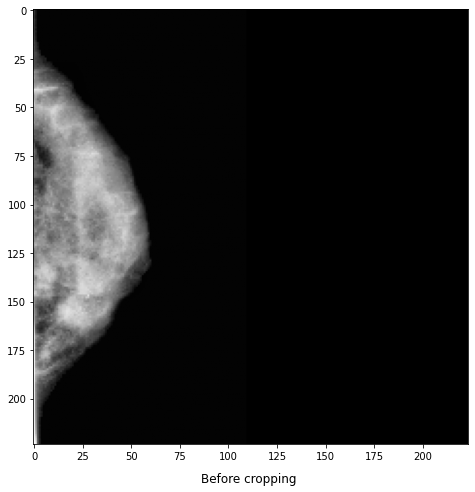

In [97]:
plt.figure(figsize = (50,8))
plt.imshow(res_x.numpy(), cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)

In [103]:
# plt.figure(figsize = (50,8))
# plt.imshow(res_y.numpy(), cmap="gray")
# plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)

(224, 224, 3)


In [109]:
prediction = unet.predict(res_x.numpy())

ValueError: ignored